In [1]:
from datasets import load_dataset

dataset = load_dataset("multi_nli")

/home/cas/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset multi_nli downloaded and prepared to /home/cas/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 258.33it/s]


In [23]:
"""
features:
- promt, pair ID
- premise (binary, parse)
- hypothesis (binary, parse)
- genre 
- label
"""
dataset['train']

Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 392702
})

In [11]:
import pandas as pd

train_df = pd.DataFrame({
    'premise': dataset['train']['premise'],
    'hypothesis': dataset['train']['hypothesis'],
    'label': dataset['train']['label']
    })

In [13]:
"""
label meanings:
0: entailment (agree)
1: neutral
2: contradiction (disagree)
"""
train_df.head()

,premise,hypothesis,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0
3,How do you know? All this is their information...,This information belongs to them.,0
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1


{2: 130903, 1: 130900, 0: 130899}


Text(0.5, 1.0, 'class distribution')

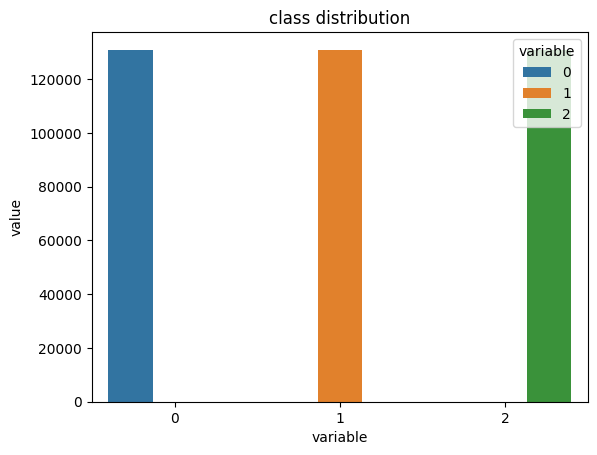

In [20]:
import seaborn as sns

# distribution of labels
class_distribution = (pd.value_counts(train_df['label'])).to_dict()
print(class_distribution)
sns.barplot(data = pd.DataFrame.from_dict([class_distribution]).melt(), x = "variable", y="value", hue="variable").set_title('class distribution')

In [47]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

def preprocess(text, lemmatizer = WordNetLemmatizer()):
    sw = set(stopwords.words('english'))
    text = re.sub(r'[^\w\s]', '', text).lower()
    s = ""
    for word in text.split():
        if word not in sw:
                s += (lemmatizer.lemmatize(word) + " ")
    return s

In [49]:
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe

tokenizer = get_tokenizer("basic_english")
max_words = 20
embed_len=300
global_vectors = GloVe(name='840B', dim=embed_len)

.vector_cache/glove.840B.300d.zip: 2.18GB [06:51, 5.29MB/s]                                
100%|█████████▉| 2196016/2196017 [02:23<00:00, 15268.03it/s]


In [116]:
import torch
# takes string, returns 6000 dim GloVe vector
def to_vector(s):
    X = tokenizer(s)
    # fill / cut tokens to max size
    if len(X) < max_words:
        X = X+[""]*(max_words-len(X))
    else:
        X = X[:max_words]

    X_tensor = torch.zeros(1, max_words, embed_len)
    for i, j in enumerate(X):
        X_tensor[0][i] = global_vectors.get_vecs_by_tokens(j)
    return(X_tensor.reshape(1, -1))

def combined_tensor(row):
    x = to_vector(row['premise'])
    y = to_vector(row['hypothesis'])

    return torch.cat((x, y), 1).numpy()

def label_colour(l):
    c = ['lime', 'blue', 'red']
    return c[l]


/tmp/ipykernel_18996/2778717.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))


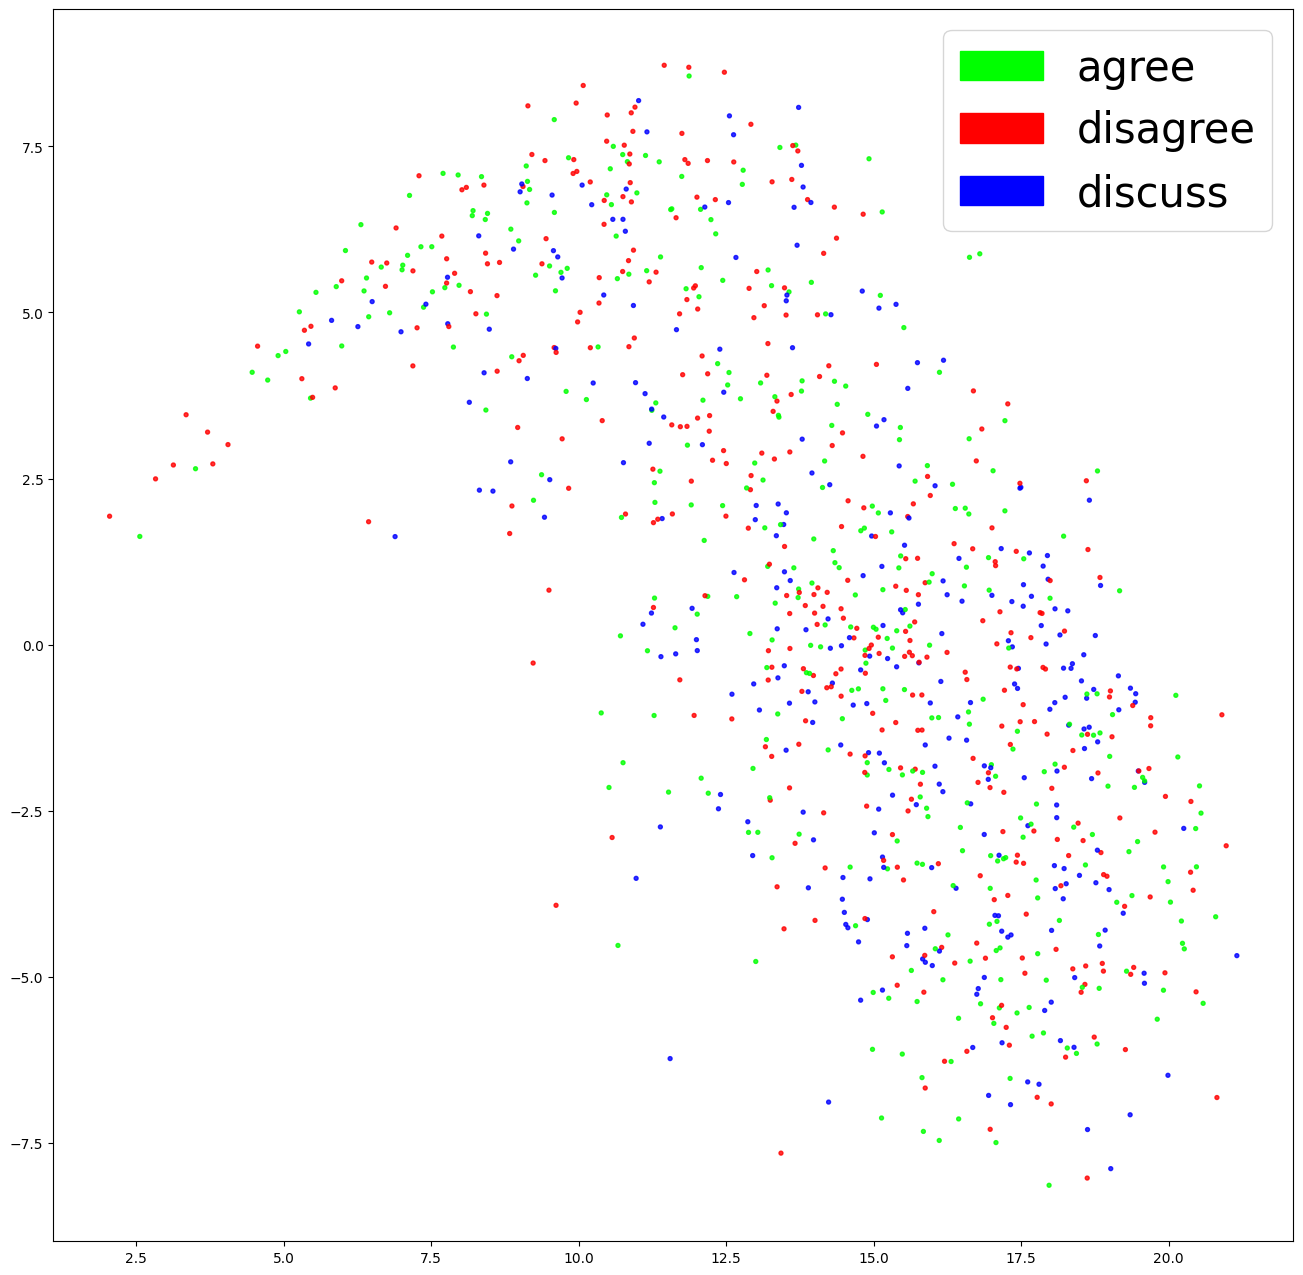

In [118]:
# sample list of target embeddings
r = 1000
targets = [combined_tensor(train_df.iloc[i])[0] for i in range(r)]

# list of the matching colour of the corresponding label
colours = [label_colour(train_df.iloc[i]['label']) for i in range(r)]

# create dimension reduced scatter plot of embeddings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import TruncatedSVD

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ["lime","red","blue"]
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            green_patch = mpatches.Patch(color='lime', label='agree')
            red_patch = mpatches.Patch(color="red", label='disagree')
            blue_patch = mpatches.Patch(color="blue", label='discuss')
            plt.legend(handles=[green_patch, red_patch, blue_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(targets, colours)
plt.show()

In [127]:

import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyperparameters
in_dim = 12000
hidden_dim = 120
out_dim = 3
epochs = 30
lr = 0.001

# define neural net
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(NN, self).__init__()

        # define layers
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, out_dim)
    
    # applies layers with sample x
    def forward(self, x):
        out = self.l1(x).squeeze()
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NN(in_dim, hidden_dim, out_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [130]:
# pytorch data loading
from torch.utils.data import DataLoader

def load_dataloader(split: str, batch: int):
    ds = dataset[split].with_format('torch')
    dl = DataLoader(ds, batch_size=batch, shuffle=True)   
    return dl

train_dl = load_dataloader('train', 1)

"""
Since we have batch=4, we get 4 datapoints. 
Each index of the label tensor belongs to one text pair.
"""

# test and display dataloader for 1 batch
for idx, batch in enumerate(train_dl):
    print(batch['hypothesis'], '\n\n', batch['premise'], '\n\n', batch['label'])
    break

['Annette saved his life.'] 

 ['The original of that photograph was the French girl, Annette, who saved his life."'] 

 tensor([0])


In [132]:
"""
training loop
"""
loss_vals=  {}
loss_vals['train'] = []
loss_vals['test'] = []


for epoch in range(10):
    running_loss = 0.
    last_loss = 0.
    epoch_loss = []

    # enumerate to track the batch index and do some intra-epoch reporting
    for i, sample in enumerate(train_dl):
        # zero gradients each batch
        optimizer.zero_grad()
        
        # cerate combined tensor
        inputs = combined_tensor(sample).float()
        labels = sample['label']

        # predict for batch
        outputs = model(inputs)

        # compute loss and gradients
        loss = criterion(outputs, labels)
        epoch_loss.append(loss.item())
        loss.backward()

        # adjust weights
        optimizer.step()

        # report
        running_loss += loss.item()
        if i % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('Epoch {} batch {} loss: {}'.format(epoch + 1, i + 1, last_loss))
            running_loss = 0.
        
    # append avg loss per epoch to loss vals
    loss_vals['train'].append(sum(epoch_loss)/len(epoch_loss))

KeyError: 0